In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# 1. Make Data X_train, y_train, X_test, y_test

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [5]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_211018_includeDigest.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_211018_includeDigest.csv')

inp = open(file_path+'detect_peptide_train_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

In [6]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 641892 peptides and skipped 0
Loading input peptides
Succesfully loaded 129204 peptides and skipped 0
(513513, 81) (128379, 81) (129204, 81) (513513,) (128379,) (129204,)


# 2. train

In [7]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=81),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 81, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 81, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
__________________

In [8]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 513513 samples, validate on 128379 samples
Epoch 1/200
513513/513513 [==============================] - 58s 113us/sample - loss: 0.6252 - acc: 0.7221 - val_loss: 0.6143 - val_acc: 0.7492
Epoch 2/200
513513/513513 [==============================] - 57s 111us/sample - loss: 0.6132 - acc: 0.7591 - val_loss: 0.6112 - val_acc: 0.7616
Epoch 3/200
513513/513513 [==============================] - 57s 111us/sample - loss: 0.6116 - acc: 0.7639 - val_loss: 0.6104 - val_acc: 0.7726
Epoch 4/200
513513/513513 [==============================] - 57s 111us/sample - loss: 0.6106 - acc: 0.7660 - val_loss: 0.6089 - val_acc: 0.7702
Epoch 5/200
513513/513513 [==============================] - 57s 110us/sample - loss: 0.6084 - acc: 0.7700 - val_loss: 0.6056 - val_acc: 0.7740
Epoch 6/200
513513/513513 [==============================] - 58s 112us/sample - loss: 0.6052 - acc: 0.7760 - val_loss: 0.6034 - val_acc: 0.7741
Epoch 7/200
513513/513513 [==============================] - 57s 111us/sample - loss

513513/513513 [==============================] - 79s 155us/sample - loss: 0.5872 - acc: 0.8137 - val_loss: 0.5889 - val_acc: 0.8115
Epoch 114/200
513513/513513 [==============================] - 84s 164us/sample - loss: 0.5871 - acc: 0.8140 - val_loss: 0.5888 - val_acc: 0.8095
Epoch 115/200
513513/513513 [==============================] - 83s 162us/sample - loss: 0.5873 - acc: 0.8133 - val_loss: 0.5910 - val_acc: 0.8139
Epoch 116/200
513513/513513 [==============================] - 85s 165us/sample - loss: 0.5871 - acc: 0.8136 - val_loss: 0.5888 - val_acc: 0.8098
Epoch 117/200
513513/513513 [==============================] - 80s 157us/sample - loss: 0.5871 - acc: 0.8137 - val_loss: 0.5891 - val_acc: 0.8130
Epoch 118/200
513513/513513 [==============================] - 84s 163us/sample - loss: 0.5870 - acc: 0.8139 - val_loss: 0.5889 - val_acc: 0.8119
Epoch 119/200
513513/513513 [==============================] - 78s 151us/sample - loss: 0.5870 - acc: 0.8142 - val_loss: 0.5887 - val_acc:

513513/513513 [==============================] - 111s 216us/sample - loss: 0.5859 - acc: 0.8166 - val_loss: 0.5887 - val_acc: 0.8124
Epoch 170/200
513513/513513 [==============================] - 110s 215us/sample - loss: 0.5859 - acc: 0.8168 - val_loss: 0.5894 - val_acc: 0.8146
Epoch 171/200
513513/513513 [==============================] - 116s 225us/sample - loss: 0.5860 - acc: 0.8164 - val_loss: 0.5893 - val_acc: 0.8160
Epoch 172/200
513513/513513 [==============================] - 108s 210us/sample - loss: 0.5858 - acc: 0.8170 - val_loss: 0.5886 - val_acc: 0.8121
Epoch 173/200
513513/513513 [==============================] - 113s 220us/sample - loss: 0.5861 - acc: 0.8154 - val_loss: 0.5889 - val_acc: 0.8071
Epoch 174/200
513513/513513 [==============================] - 116s 226us/sample - loss: 0.5859 - acc: 0.8165 - val_loss: 0.5888 - val_acc: 0.8138
Epoch 175/200
513513/513513 [==============================] - 106s 206us/sample - loss: 0.5861 - acc: 0.8159 - val_loss: 0.5893 - v

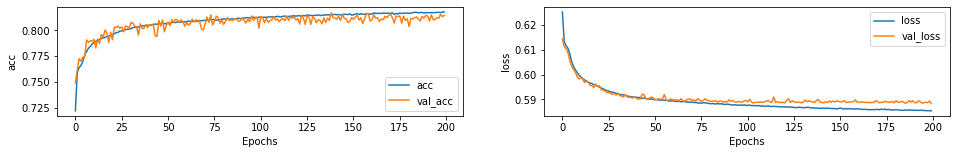

In [9]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

129204/129204 [==============================] - 14s 109us/sample - loss: 0.5874 - acc: 0.8279
Test Accuracy: [0.5874124614673002, 0.8278923]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     64602
           1       0.83      0.82      0.83     64602

    accuracy                           0.83    129204
   macro avg       0.83      0.83      0.83    129204
weighted avg       0.83      0.83      0.83    129204

rf auc : 0.8900816168922037


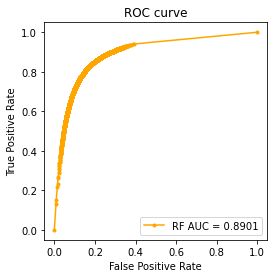

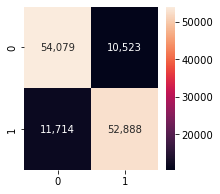

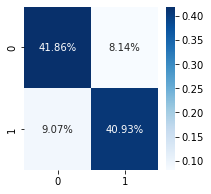

In [11]:
test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# initial model test
 - AUC 91? 93?

In [26]:
df_gpmdb = pd.read_csv('../compareModel/2019Bioinformatics_DeepMSPeptide/Datasets/GPMDB_training_peptides.txt', sep='\t')
df_gpmdb = df_gpmdb[['Peptide_seq', 'Class']]
y_train_gpmdb = df_gpmdb['Class'].apply(lambda x: {'MObs':1, 'LObs':0}[x]).values
Xs = df_gpmdb.Peptide_seq.values
max_len=81
aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in Xs:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
X_train_gpmdb = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

In [28]:
model.fit(X_train_gpmdb, y_train_gpmdb, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 74998 samples, validate on 84295 samples
Epoch 1/200
74998/74998 [==============================] - 27s 363us/sample - loss: 0.6419 - acc: 0.7020 - val_loss: 0.5907 - val_acc: 0.7847
Epoch 2/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.6245 - acc: 0.7412 - val_loss: 0.5896 - val_acc: 0.7884
Epoch 3/200
74998/74998 [==============================] - 28s 368us/sample - loss: 0.6232 - acc: 0.7450 - val_loss: 0.5884 - val_acc: 0.7919
Epoch 4/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6222 - acc: 0.7468 - val_loss: 0.5855 - val_acc: 0.8018
Epoch 5/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6215 - acc: 0.7479 - val_loss: 0.5924 - val_acc: 0.7799
Epoch 6/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6209 - acc: 0.7505 - val_loss: 0.5893 - val_acc: 0.7897
Epoch 7/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6206 - acc: 

74998/74998 [==============================] - 28s 369us/sample - loss: 0.6132 - acc: 0.7640 - val_loss: 0.5968 - val_acc: 0.7668
Epoch 59/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6131 - acc: 0.7643 - val_loss: 0.5979 - val_acc: 0.7641
Epoch 60/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.6132 - acc: 0.7635 - val_loss: 0.5940 - val_acc: 0.7756
Epoch 61/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.6130 - acc: 0.7639 - val_loss: 0.5917 - val_acc: 0.7849
Epoch 62/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.6129 - acc: 0.7648 - val_loss: 0.5986 - val_acc: 0.7619
Epoch 63/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.6128 - acc: 0.7650 - val_loss: 0.5952 - val_acc: 0.7725
Epoch 64/200
74998/74998 [==============================] - 28s 368us/sample - loss: 0.6129 - acc: 0.7649 - val_loss: 0.5986 - val_acc: 0.7627
Epoch 65/200

Epoch 172/200
74998/74998 [==============================] - 28s 372us/sample - loss: 0.5962 - acc: 0.8153 - val_loss: 0.6167 - val_acc: 0.7359
Epoch 173/200
74998/74998 [==============================] - 28s 372us/sample - loss: 0.5963 - acc: 0.8157 - val_loss: 0.6151 - val_acc: 0.7419
Epoch 174/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.5960 - acc: 0.8165 - val_loss: 0.6150 - val_acc: 0.7407
Epoch 175/200
74998/74998 [==============================] - 28s 374us/sample - loss: 0.5960 - acc: 0.8163 - val_loss: 0.6171 - val_acc: 0.7353
Epoch 176/200
74998/74998 [==============================] - 28s 371us/sample - loss: 0.5963 - acc: 0.8147 - val_loss: 0.6157 - val_acc: 0.7365
Epoch 177/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.5959 - acc: 0.8166 - val_loss: 0.6174 - val_acc: 0.7324
Epoch 178/200
74998/74998 [==============================] - 28s 370us/sample - loss: 0.5954 - acc: 0.8171 - val_loss: 0.6167 - val_acc:

88998/88998 [==============================] - 7s 77us/sample - loss: 0.3391 - acc: 0.8542 - binary_crossentropy: 0.3391
Test Loss: 0.569490050697046
Test Accuracy: [0.33912464481447113, 0.8541877, 0.33912423]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     44509
           1       0.81      0.92      0.86     44489

    accuracy                           0.85     88998
   macro avg       0.86      0.85      0.85     88998
weighted avg       0.86      0.85      0.85     88998

rf auc : 0.9339800137281874


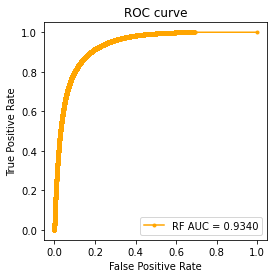

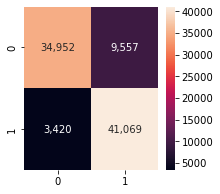

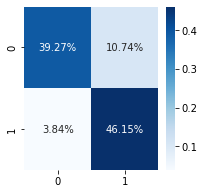

In [14]:
test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# GPMDB를 학습하면 성능이 더 좋아지므로 DeepMSpeptide의 파라메터를 초기화할 필요가 있다.